In [7]:
# Import the necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd

import lightgbm as lgb
import pickle

from sklearn.model_selection import KFold

from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import accuracy_score as acs_score

from src.data.data_fetcher import get_raw_data
from src.features.preprocess_data import get_preprocessed_test_data, fetch_preprocessed_data
pd.set_option('display.max_columns', 200)

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [8]:
# Prepare data
train_a, train_b, train_c, X_train_estimated_a, X_train_estimated_b, X_train_estimated_c, X_train_observed_a, X_train_observed_b, X_train_observed_c, X_test_estimated_a, X_test_estimated_b, X_test_estimated_c = get_raw_data()

X_train_obs_combined, X_val_obs_combined, y_train_obs_combined, y_val_obs_combined, X_train_est_combined, X_val_est_combined, y_train_est_combined, y_val_est_combined = fetch_preprocessed_data()
x_test_whole = get_preprocessed_test_data()

x_whole = pd.concat([X_train_obs_combined, X_val_obs_combined])
y_whole = pd.concat([y_train_obs_combined, y_val_obs_combined])
x_whole.reset_index(drop=True, inplace=True)
y_whole.reset_index(drop=True, inplace=True)

x_whole.head()

X_test_estimated_a.shape = (2880, 47), X_test_estimated_b.shape = (2880, 47), X_test_estimated_c.shape = (2880, 47)
After temporal alignment
X_test_estimated_a.shape = (720, 47), X_test_estimated_b.shape = (720, 47), X_test_estimated_c.shape = (720, 47)
X_test_estimated_a_processed.shape = (720, 46), X_test_estimated_b_processed.shape = (720, 46), X_test_estimated_c_processed.shape = (720, 46)


,absolute_humidity_2m:gm3,air_density_2m:kgm3,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,is_day:idx,is_in_shadow:idx,precip_5min:mm,precip_type_5min:idx,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sun_azimuth:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,location_a,location_b,location_c,sin_day_of_year,cos_day_of_year,sin_hour,cos_hour,sun_product,modified_solar_elevation,effective_radiation,time_since_prediction,cloud_ratio,cloud_cover_over_30%,sun_addition,is_freezing,is_snow,is_rain
0,15.2,1.18175,1.351672e+06,440.600006,7231.174805,0.0,291.250000,95.500000,294605.53125,271.225006,872357.56250,54.224998,1.0,0.0,0.0,0.0,1007.500000,0.0,0.0,72.375000,92.172501,0.00,294.625000,98.925003,48152.375000,2.125,-2.000,-0.750,0.0,1,0,0,0.027950,-0.999609,1.000000,6.123234e-17,25901.988281,0.455669,0.645392,0,0.548142,1,366.725006,0,0,0
1,13.7,1.19250,2.456032e+06,637.599976,1410.500000,0.0,289.399994,145.525009,447652.68750,5.800000,11749.87500,99.675003,1.0,0.0,0.0,0.0,1001.400024,0.0,0.1,80.699997,236.257751,0.10,292.100006,100.000000,5903.875000,1.350,-1.225,0.525,0.0,0,1,0,-0.310857,-0.950457,-0.500000,-8.660254e-01,844.045105,0.611489,0.004784,0,0.996750,1,151.325012,0,0,0
2,10.5,1.20150,2.172293e+05,107.400002,2315.000000,0.0,285.299988,42.200001,100314.65625,65.099998,135992.90625,23.299999,1.0,0.0,0.0,0.0,1006.849976,0.0,0.0,59.049999,85.390503,0.00,291.700012,43.549999,49974.699219,3.375,-0.400,3.350,0.0,1,0,0,-0.804826,-0.593511,0.965926,2.588190e-01,2747.219971,0.164161,0.626034,0,0.535017,0,107.300003,0,0,0
3,6.3,1.24800,0.000000e+00,0.000000,131.375000,0.0,277.100006,0.000000,0.00000,0.000000,0.00000,99.574997,0.0,1.0,0.0,0.0,992.949951,0.0,0.0,93.650002,127.701752,0.35,278.100006,99.974998,3399.375000,6.000,5.950,-0.500,0.0,1,0,0,-0.141444,0.989946,0.965926,-2.588190e-01,0.000000,0.000000,0.000000,0,0.995999,1,0.000000,0,0,0
4,6.3,1.27175,0.000000e+00,0.000000,8580.474609,0.0,277.000000,0.000000,0.00000,0.000000,0.00000,49.400002,0.0,1.0,0.0,0.0,1012.200012,0.0,0.0,81.649994,346.724243,0.00,278.600006,98.824997,27873.150391,1.450,1.450,-0.275,0.0,1,0,0,0.931210,-0.364483,-0.500000,8.660254e-01,0.000000,0.000000,0.000000,0,0.499874,1,0.000000,0,0,0


In [9]:
import lightgbm as lgb
from sklearn.model_selection import KFold
import pandas as pd

# Assuming x_whole and y_whole are defined and are pandas DataFrames

num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
total_mae = 0

reg_models = []

params = {
    'objective': 'regression',
    'boosting_type': 'gbdt',
    'metric': 'mae',
    'num_leaves': 31,
    'learning_rate': 0.001,
    'feature_fraction': 0.9,
    'max_depth': -1,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'min_data_in_leaf': 20,
    'early_stopping_rounds': 100,
    'verbosity': 0,  # 0 for verbose, -1 for silent
}

num_round = 100000 # number of training iterations

# Ensure column names are compatible with LightGBM
x_whole.columns = x_whole.columns.str.replace('[^A-Za-z0-9_]', '_', regex=True)

for train_index, test_index in kf.split(x_whole):
    X_train, X_test = x_whole.iloc[train_index], x_whole.iloc[test_index]
    y_train, y_test = y_whole.iloc[train_index], y_whole.iloc[test_index]

    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_test, label=y_test)

    reg = lgb.train(params, train_data, num_round, valid_sets=[valid_data])
    reg_models.append(reg)
    predictions = reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, predictions)
    total_mae += mae
    
    print(f"Fold {total_mae}, Mean Absolute Error: {mae}")

average_mse = total_mae / num_folds
print(f"Average Mean Squared Error: {average_mse}")

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.882620
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.367411
[LightGBM] [Debug] init for col-wise cost 0.010697 seconds, init for row-wise cost 0.009552 seconds
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7503
[LightGBM] [Info] Number of data points in the train set: 61635, number of used features: 45
[LightGBM] [Debug] Use subset for bagging
[LightGBM] [Info] Start training from score 320.776814
[LightGBM] [Debug] Re-bagging, using 49376 data to train
[LightGBM] [Debug] Trained a tree with leaves = 256 and depth = 18
Training until validation scores don't improve for 100 rounds
[LightGBM] [Debug] Trained a tree with leaves = 256 and depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 256 and depth = 17
[LightGBM] [Debug] Trained a tree wit

Exception ignored on calling ctypes callback function: <function _log_callback at 0x000002A5A63FC940>
Traceback (most recent call last):
  File "c:\Users\gunna\Documents\Maskinlæring\Prosjekt\power-predictor\venv\lib\site-packages\lightgbm\basic.py", line 203, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


Trained a tree with leaves = 256 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 256 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 256 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 256 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 256 and depth = 16
[LightGBM] [Debug] Re-bagging, using 49557 data to train
[LightGBM] [Debug] Trained a tree with leaves = 256 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 256 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 256 and depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 256 and depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 256 and depth = 15
[LightGBM] [Debug] Re-bagging, using 49387 data to train
[LightGBM] [Debug] Trained a tree with leaves = 256 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 256 and depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 256 and depth = 18
[LightGBM] [Debug] Trained a tree 

In [ ]:
def multi_predict(x_values :pd.DataFrame, models) -> pd.DataFrame:
    """
    Function for predicting on multiple models and averaging the results
    """
    results = models[0].predict(x_values)
    for model in models[1:]:
        prediction = model.predict(x_values)
        results += prediction
    
    results = results / len(models)

    return pd.DataFrame(results)


In [ ]:
train_prediction = multi_predict(x_whole, reg_models)

test_prediction = multi_predict(X_val_est_combined, reg_models)

# Evaluate the best model on the validation subset of the observed dataset
# leaderboard = automl.get_leaderboard()
# print(leaderboard)

mae_observed = mean_absolute_error(y_val_est_combined, test_prediction)

print(f'Mean Absolute Error on Validation Set: {mae_observed}')

Mean Absolute Error on Validation Set: 380.75852194155686


# Visualization

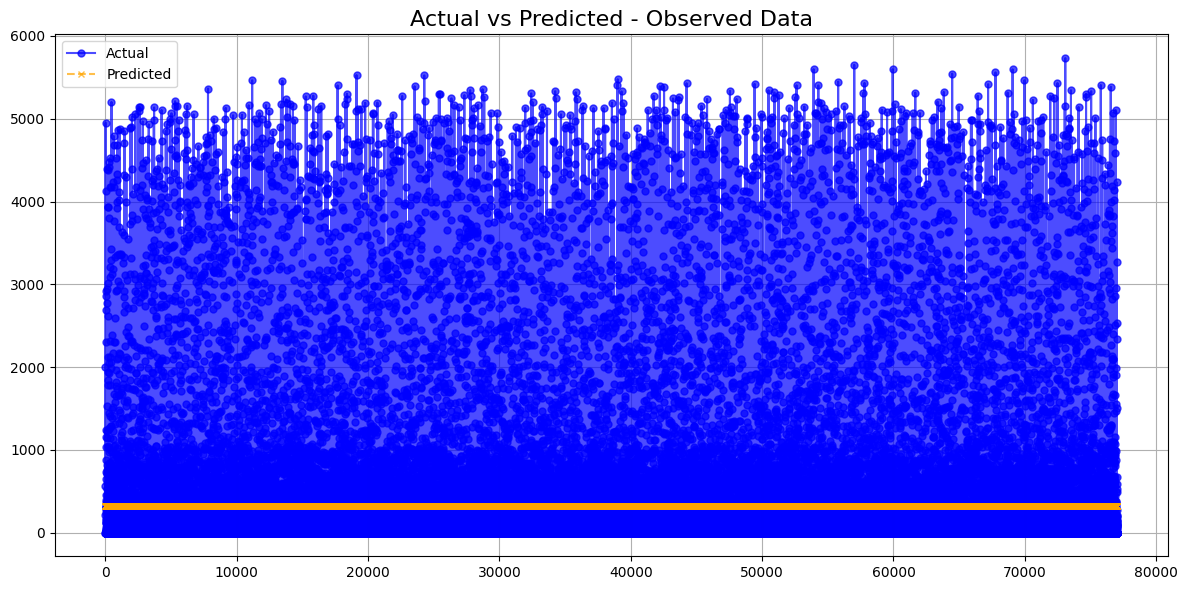

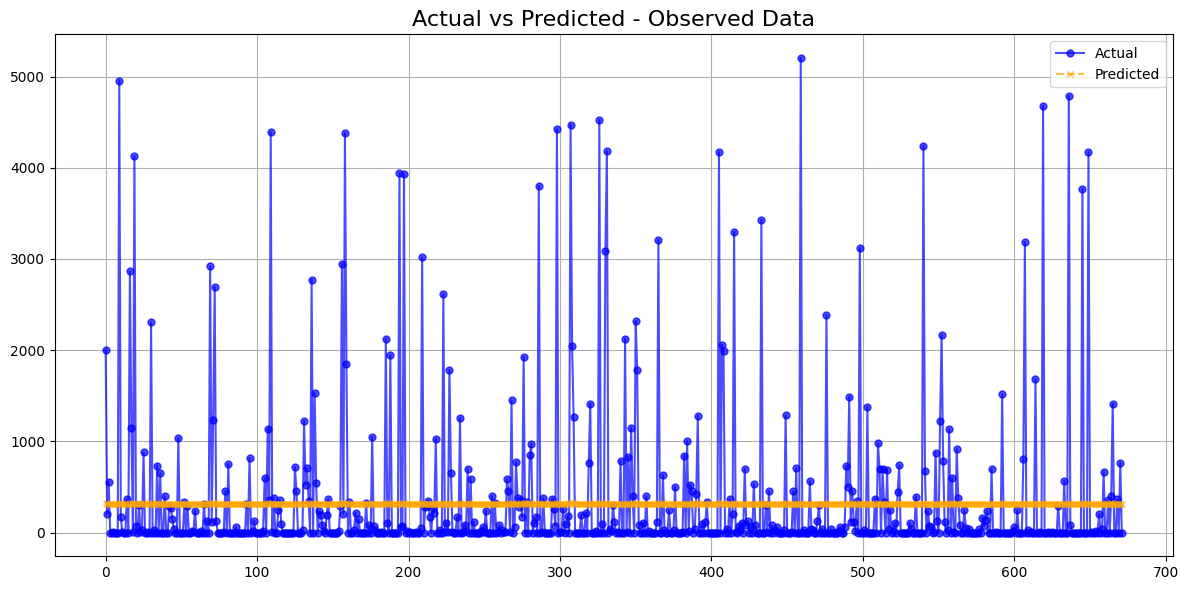

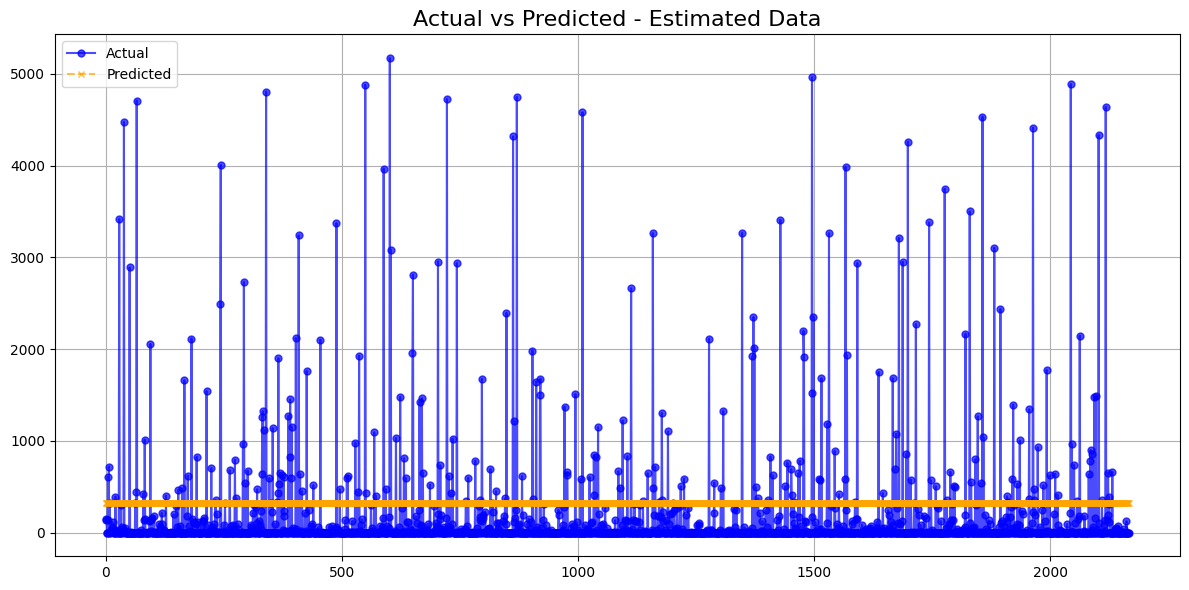

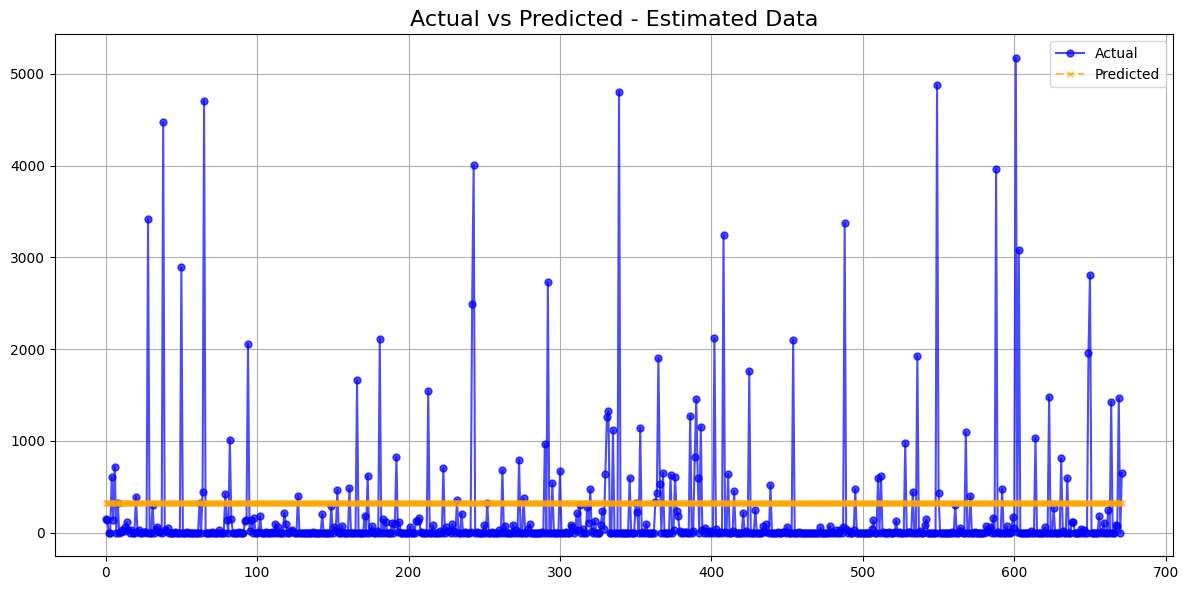

In [ ]:
import matplotlib.pyplot as plt

# Observed Data
# Set up the plotting area
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_whole.reset_index(drop=True), label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(train_prediction, label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
# Titles and labels
plt.title('Actual vs Predicted - Observed Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualise the monthly predictions
# Observed Data
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_whole.reset_index(drop=True)[:24*7*4], label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(train_prediction[:24*7*4], label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
# Titles and labels
plt.title('Actual vs Predicted - Observed Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Estimated Data
# Set up the plotting area
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_val_est_combined.reset_index(drop=True), label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(test_prediction, label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
# Titles and labels
plt.title('Actual vs Predicted - Estimated Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Visualise the monthly predictions
# Estimated Data
plt.figure(figsize=(12, 6))
# Line plot of Actual values
plt.plot(y_val_est_combined.reset_index(drop=True)[:24*7*4], label='Actual', linestyle='-', marker='o', markersize=5, alpha=0.7, color='blue')
# Line plot of Predicted values
plt.plot(test_prediction[:24*7*4], label='Predicted', linestyle='--', marker='x', markersize=5, alpha=0.7, color='orange')
plt.title('Actual vs Predicted - Estimated Data', fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
with open("lightgbm_models.pkl", "wb") as file:
    pickle.dump(reg_models, file)

In [ ]:
with open("lightgbm_models.pkl", "rb") as file:
    loaded_reg_models = pickle.load(file)

In [ ]:
y_pred = multi_predict(x_test_whole, reg_models)

In [ ]:
# Save the model
from src.models.saving import save_predictions

save_predictions(y_pred, 'lightgbm')

   id  prediction
0   0  317.629998
1   1  317.629998
2   2  317.629998
3   3  317.629998
4   4  318.155857
